# Imports

In [1]:
import t3f
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

/Users/mathemage/anaconda3/envs/tf/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/mathemage/anaconda3/envs/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from environments import Snake
from methods import ReplayMemory

# Experiments

In [3]:
def tf_repeat(x, num):
    u = tf.reshape(x, (-1, 1))
    ones = tf.ones(1, dtype=tf.int32)
    u = tf.tile(u, tf.concat([ones, num], axis=0))
    u = tf.reshape(u, (-1, 1))
    return u

In [4]:
class QQTT:
    
    def __init__(self, num_actions, num_colors=4, state_shape=[8, 8, 1],
                 tt_rank=8, optimizer=tf.train.AdamOptimizer(2.5e-4), 
                 dtype=tf.float32, scope="qqtt_network", reuse=False):
        
        input_shape = np.prod(state_shape) * [num_colors,] + [num_actions,]
        
        with tf.variable_scope(scope, reuse=reuse):
            
        # random initialization of Q-tensor
            q0init = t3f.random_tensor(shape=input_shape, tt_rank=tt_rank, stddev=1e-3)
            q0init = t3f.cast(q0init, dtype=dtype)
            q0 = t3f.get_variable('Q', initializer=q0init)
        
            self.input_states = tf.placeholder(dtype=tf.int32, shape=[None]+state_shape)
            self.input_actions = tf.placeholder(dtype=tf.int32, shape=[None])
            self.input_targets = tf.placeholder(dtype=dtype, shape=[None])

            reshaped_s = tf.reshape(self.input_states, (-1, np.prod(state_shape)))
            reshaped_a = tf.reshape(self.input_actions, (-1, 1))
            input_s_and_a = tf.concat([reshaped_s, reshaped_a], axis=1) 
            self.q_selected = t3f.gather_nd(q0, input_s_and_a, dtype=dtype)

            reshaped_s_ = tf.reshape(self.input_states, [-1]+state_shape)
            
            # some shitty code
            s_a_idx = tf.concat(num_actions * [reshaped_s], axis=0) 
            actions_range = tf.range(start=0, limit=num_actions)
            a_idx = tf_repeat(actions_range, tf.shape(self.input_states)[0:1])
            s_a_idx = tf.concat([s_a_idx, a_idx], axis=1)
            vals = t3f.gather_nd(q0, s_a_idx, dtype=dtype)
            q_values = tf.transpose(tf.reshape(vals, shape=(num_actions, -1)))
            # shitty code ends here
            
            self.q_argmax = tf.argmax(q_values, axis=1)
            self.q_max = tf.reduce_max(q_values, axis=1)
            
            self.loss = tf.losses.huber_loss(self.q_selected, self.input_targets)
            self.update_model = optimizer.minimize(self.loss)
        
    def update(self, sess, states, actions, targets):
        feed_dict = {self.input_states:states,
                     self.input_actions:actions,
                     self.input_targets:targets}
        sess.run(self.update_model, feed_dict)
        
    def get_q_action_values(self, sess, states, actions):
        feed_dict = {self.input_states:states,
                     self.input_actions:actions}
        return sess.run(self.q_selected, feed_dict=feed_dict)
        
    def get_q_argmax(self, sess, states):
        feed_dict = {self.input_states:states}
        return sess.run(self.q_argmax, feed_dict=feed_dict)
    
    def get_q_max(self, sess, states):
        feed_dict = {self.input_states:states}
        return sess.run(self.q_max, feed_dict=feed_dict)

In [5]:
batch_size = 32

replay_memory_size=50000
replay_start_size=10000
init_eps=1
final_eps=0.1
annealing_steps=100000
gamma=0.999
max_episode_length=100
num_episodes = 1000000

In [6]:
train_env = Snake(grid_size=(6, 6))

In [7]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-4
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 10000, 0.99, staircase=True)
opt = tf.train.AdamOptimizer(learning_rate)

In [8]:
qqtt_agent = QQTT(4, state_shape=[6, 6, 1], tt_rank=16, scope="fuck", optimizer=opt)

In [9]:
rep_buffer = ReplayMemory(replay_memory_size)
frame_count = 0
while (frame_count < replay_start_size):
    s = train_env.reset()
    for time_step in range(max_episode_length):
        a = np.random.randint(4)
        s_, r, end = train_env.step(a)
        if r == 0: r = -0.01
        rep_buffer.push(s, a, r, s_, end)
        s = s_
        frame_count += 1
        if end:
            break

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
train_rewards = []
eps = 0.9
fact = 0.999
for i in range(num_episodes):
    s = train_env.reset()
    R = 0
    for time_step in range(max_episode_length):
        
        if np.random.rand() < max(eps, 0.01):
            a = np.random.randint(0, 4)
        else:
            a = qqtt_agent.get_q_argmax(sess, [s])[0]
        eps = eps - 1e-6
        s_, r, done = train_env.step(a)
        R += r
        if r == 0: r = -0.01
        rep_buffer.push(s, a, r, s_, end)
        s = s_

        if time_step % 4 == 0:
            batch = rep_buffer.get_batch(batch_size)
            
            q_ = qqtt_agent.get_q_max(sess, batch.s_)
            targets = batch.r + gamma * q_ * batch.end
            
            qqtt_agent.update(sess, batch.s, batch.a, targets)
            
        if done: break
    train_rewards.append(R) 
    if i % 500 == 0:
        avg_reward = np.mean(train_rewards[-500:])
        max_reward = np.max(train_rewards[-500:])
        print("Train info:", avg_reward, max_reward) 

Train info: -1.0 -1
Train info: -0.882 2
Train info: -0.842 1
Train info: -0.858 1
Train info: -0.86 2
Train info: -0.896 1
Train info: -0.902 1
Train info: -0.868 1
Train info: -0.88 2
Train info: -0.866 2
Train info: -0.87 2
Train info: -0.856 2
Train info: -0.86 2
Train info: -0.85 1
Train info: -0.856 1
Train info: -0.856 1
Train info: -0.874 1
Train info: -0.842 1
Train info: -0.862 1
Train info: -0.858 1


KeyboardInterrupt: 

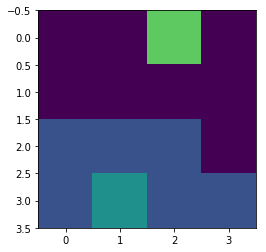

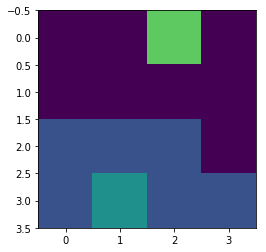

In [38]:
s = train_env.reset()
for i in range(1000):
    a = qqtt_agent.get_q_argmax(sess, [s])[0]
    s, r, done = train_env.step(a)


    train_env.plot_state()
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    #time.sleep(0.01)

    if done: break

In [12]:
eps

0.8899358000052974

In [13]:
sess.run(learning_rate)

0.00025

In [13]:
eps

-52.918600000633106